In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
# Load dataset
file_path = "UKElectricity.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)


In [ ]:
df = df[~df.index.duplicated(keep='first')]
price = df["Price"].values.reshape(-1, 1)
scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(price)

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 24
X, y = create_sequences(price_scaled, sequence_length)

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,369 (243.63 KB)

 Trainable params: 62,369 (243.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - loss: 0.0031 - val_loss: 3.5247e-04
Epoch 2/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - loss: 6.2080e-04 - val_loss: 2.5457e-04
Epoch 3/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 2.8350e-04 - val_loss: 1.1192e-04
Epoch 4/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 1.9761e-04 - val_loss: 2.2529e-04
Epoch 5/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 1.5989e-04 - val_loss: 7.5314e-05
Epoch 6/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - loss: 1.5874e-04 - val_loss: 9.0202e-05
Epoch 7/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - loss: 1.3832e-04 - val_loss: 1.1953e-04
Epoch 8/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - loss: 1.4732e-04 - val_loss: 8.0260e-05
Epoch 9/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - loss: 1.4125e-04 - val_loss: 7.5640e-05
Epoch 10/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 1.3638e-04 - val_loss: 7.5082e-05
Epoch 11/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 41

In [ ]:
y_pred = model.predict(X_test)

218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


In [ ]:
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

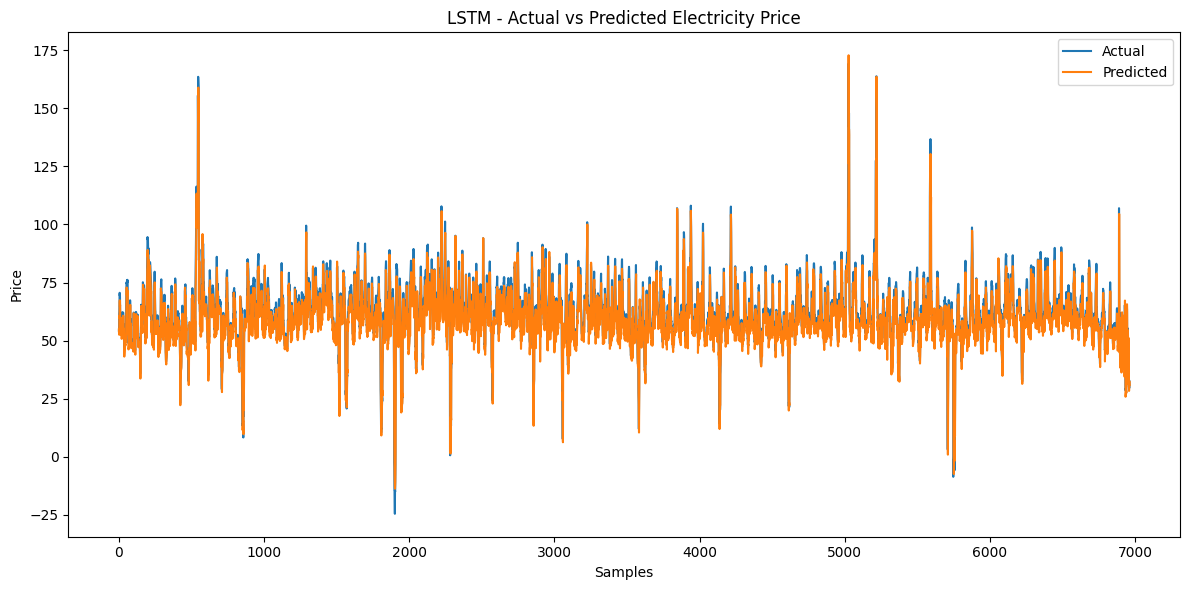

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM - Actual vs Predicted Electricity Price')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MSE: 33.50
MAE: 4.19
RMSE: 5.79
MAPE: 8.20%
R²: 0.8159


Models comparision

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

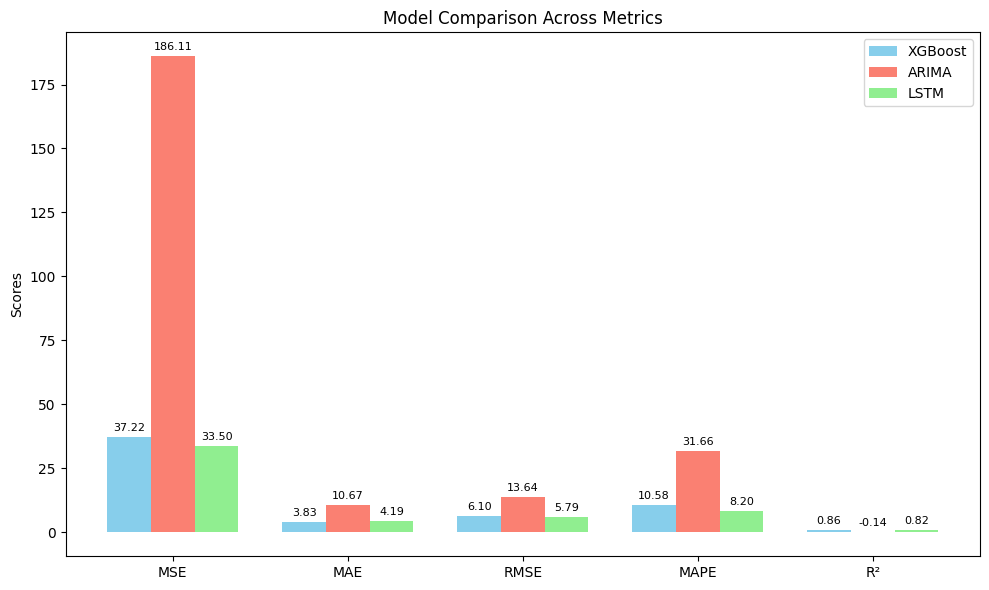

In [14]:
metrics = ['MSE', 'MAE', 'RMSE', 'MAPE', 'R²']
xgboost_scores = [37.2221, 3.8265, 6.1010, 10.5820, 0.8637]
arima_scores = [186.1077, 10.6685, 13.6421, 31.66, -0.1433]
lstm_scores = [33.50, 4.19, 5.79, 8.20, 0.8159]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, xgboost_scores, width, label='XGBoost', color='skyblue')
rects2 = ax.bar(x, arima_scores, width, label='ARIMA', color='salmon')
rects3 = ax.bar(x + width, lstm_scores, width, label='LSTM', color='lightgreen')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison Across Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()
